# Generating Weekday and Weekend profiles

In [12]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 
import re
import os

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

from kmodes.kprototypes import KPrototypes

import pandas as pd

In [13]:
pattern = f"{"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized"}/*CH*.csv"
file_paths = glob.glob(pattern)

In [14]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:15])  # Preview first 10 extracted CH... names

train_data = data_3d

n_samples = data_3d.shape[0]

Shape of the 3D array: (1481, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197', 'CH1018601234500000000000000019524', 'CH1018601234500000000000000080658', 'CH1018601234500000000000000018881', 'CH1018601234500000000000000108521', 'CH1018601234500000000000000113022']


In [15]:
#read the file according to the filenames extracted before

result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Survey/hourly_avg_clustering_category.csv')

order_dict = {house_id: i for i, house_id in enumerate(filename_list)}

# List to hold DataFrames filtered by each filename
ordered_rows = [result_df.filter(pl.col("house_id") == filename) for filename in filename_list]

# Vertically concatenate all filtered rows preserving the order
ordered_result_df = pl.concat(ordered_rows)

print(ordered_result_df['house_id'].to_list()[:10])



['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [16]:
from pandas.api.types import CategoricalDtype

# Load categorical column as pandas category
category_df = ordered_result_df.select(['electric water heating', 'building type', 'solar panels', 'electric vehicle', 'days at home']).to_pandas().astype('category')

days_at_home_categories = ['No Information', '<25%', '25-50%', '>50-75%', '>75%']
building_type_categories = ['No Information', 'Flat', 'House']

# Define fixed categories for 'age' including 'No information'
#age_categories = list(category_df['age'].cat.categories)  # existing categories
#if 'No information' not in age_categories:
#    age_categories.append('No information')

#age_cat_type = CategoricalDtype(categories=age_categories, ordered=False)
days_cat_type = CategoricalDtype(categories=days_at_home_categories, ordered=False)
building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=False)

# Convert 'age' column to the defined categorical type
#category_df['age'] = category_df['age'].astype(age_cat_type)
category_df['days at home'] = category_df['days at home'].astype(days_cat_type)
category_df['building type'] = category_df['building type'].astype(building_cat_type)

# Fill NaN with "No information"
#category_df['age'] = category_df['age'].fillna('No information')

# Convert to NumPy array
category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_array])


print(combined_data)

[[0.10906710714799749 0.11099307064379255 0.10744957197003435 ... 'no'
  'yes' '>75%']
 [0.18794544253933557 0.18459821936835402 0.18250335860828404 ... 'no'
  'no' '>50-75%']
 [0.3812608385188183 0.3719269611343441 0.3823319392022823 ... 'yes' 'no'
  '>50-75%']
 ...
 [0.1393324874959369 0.1434847801696569 0.13816858727678805 ... 'no' 'no'
  '>75%']
 [0.22523431587526382 0.2101177886014786 0.1967283100149416 ... 'no' 'no'
  '>75%']
 [0.13550171975474778 0.13695229549872842 0.12907133243606966 ... 'no'
  'no' 'No Information']]


In [17]:
# 5. Specify the categorical feature column indices (the last 3 columns)
categorical_indices = list(range(combined_data.shape[1] - 5, combined_data.shape[1]))



Clusters: 2, Cost: 4607.944382662534
Clusters: 3, Cost: 3692.724466839682
Clusters: 4, Cost: 3199.7203564907486
Clusters: 5, Cost: 2907.540335464455
Clusters: 6, Cost: 2698.3190990610265
Clusters: 7, Cost: 2567.3948970892243
Clusters: 8, Cost: 2462.588330205098
Clusters: 9, Cost: 2369.703947977521
Clusters: 10, Cost: 2290.8579526080484


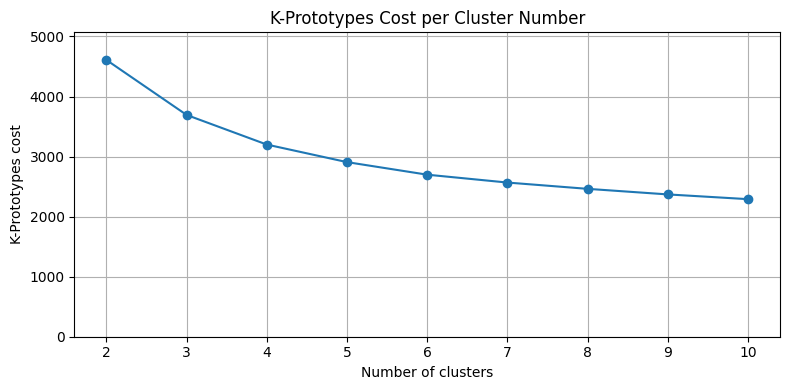

In [43]:


cluster_range = range(2, 11)  # Try 2-10 clusters

costs = []

for n_clusters in cluster_range:
    kproto = KPrototypes(
        n_clusters=n_clusters,
        init='Cao',
        verbose=0,
        max_iter=200,
        gamma=0,
        random_state=42,
        n_init=10
    )
    kproto.fit_predict(combined_data, categorical=categorical_indices)
    costs.append(kproto.cost_)
    print(f"Clusters: {n_clusters}, Cost: {kproto.cost_}")

# Plotting the cost vs number of clusters
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, costs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('K-Prototypes cost')
plt.ylim(0, max(costs) * 1.1)
plt.title('K-Prototypes Cost per Cluster Number')
plt.xticks(cluster_range)
plt.grid(True)
plt.tight_layout()
plt.savefig(
f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/kPrototypes_cost.png'
)
plt.show()

In [ ]:
# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(
    n_clusters=4, 
    init='Cao', 
    verbose=0, 
    max_iter=200, 
    gamma=2,
    random_state=42,
    n_init=10
)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

clusters = clusters + 1

print("Cluster labels:")
print(clusters)

Cluster labels:
[1 1 4 ... 1 1 1]


In [37]:
print(clusters)

remap = {3: 4, 4: 1, 1: 2, 2: 3}
clusters = np.vectorize(remap.get)(clusters)

print(clusters)

[1 1 4 ... 1 1 1]
[2 2 1 ... 2 2 2]


In [38]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters
}).sort("cluster")

result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering_kProt.csv")

Cluster 1 size: 292
Cluster 2 size: 785
Cluster 3 size: 230
Cluster 4 size: 174


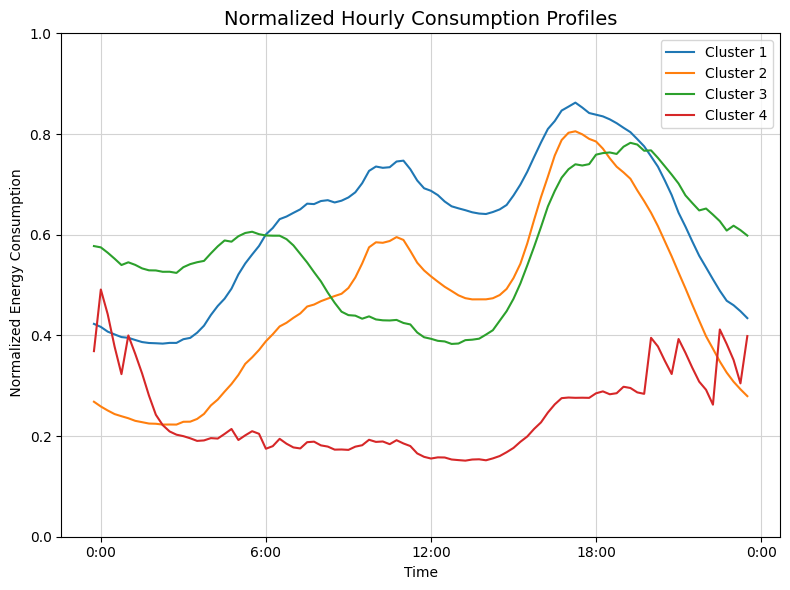

In [39]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

plt.figure(figsize=(8, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title("Normalized Hourly Consumption Profiles", fontsize=14)
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
#plt.xticks(range(1,108,12),labels=labels)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
#plt.legend()
#plt.margins(0)
plt.grid(True, color = 'lightgray')
plt.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/HourlyAveraged_KProt.png",
    bbox_inches='tight'
    )
plt.show()



In [45]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/DATA/Cluster/hourly_avg_clustering_kProt.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

print(cluster_summary)

shape: (4, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 292            ┆ 5009.66                     ┆ 8.51                        │
│ 2       ┆ 785            ┆ 2956.43                     ┆ 5.13                        │
│ 3       ┆ 230            ┆ 8747.21                     ┆ 13.92                       │
│ 4       ┆ 174            ┆ 7137.18                     ┆ 11.96                       │
└─────────┴────────────────┴─────────────────────────────┴─────────────────────────────┘


Cluster 1: PAR = 1.39
Cluster 2: PAR = 1.71
Cluster 3: PAR = 1.38
Cluster 4: PAR = 2.02


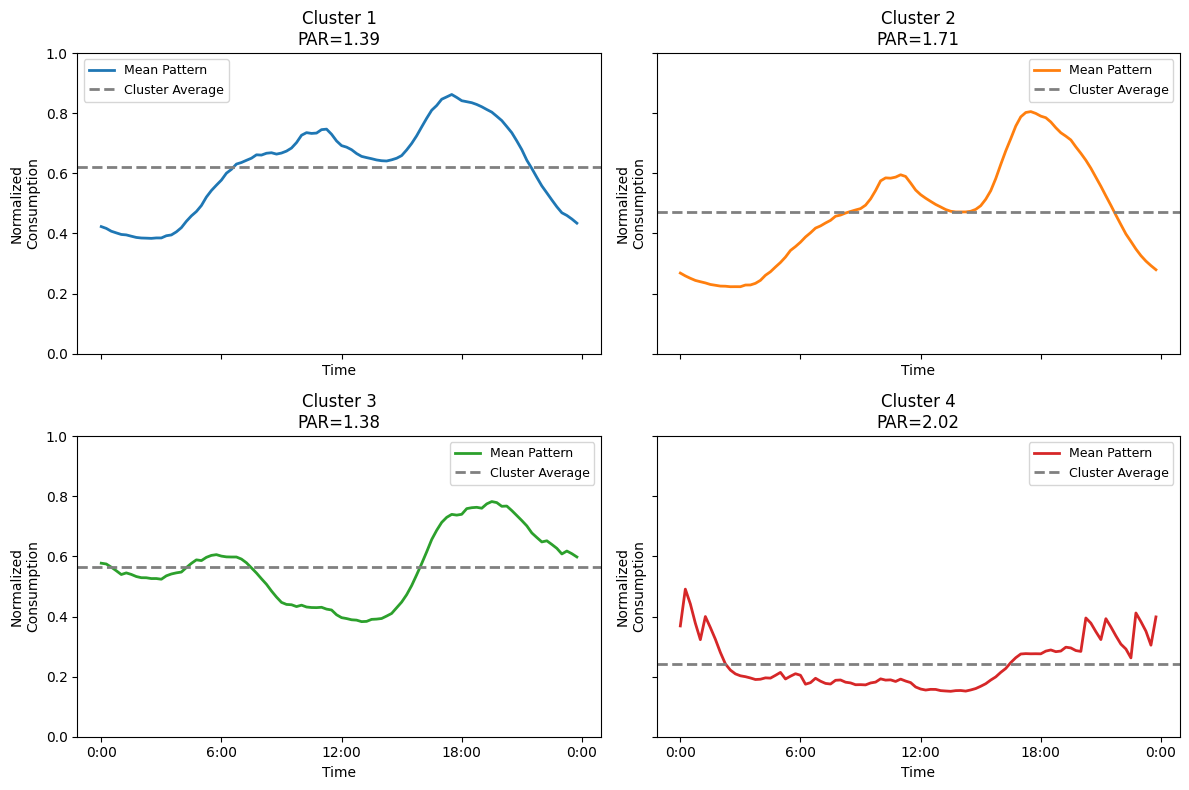

In [42]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']

# Compute the mean time series and PAR for each cluster and store for subplot
mean_time_series_all = []
mean_lines = []

n_clusters_to_plot = np.unique(clusters)
f, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
axs = axs.flatten()

for cl in n_clusters_to_plot:
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)
    print(f"Cluster {cl}: PAR = {PAR_max/PAR_average:.2f}")

    # Individual plots (optional)
    
    # Subplot (2x2)
    ax = axs[cl-1]
    ax.plot(range(1,97), mean_time_series.ravel()[:96], 
                 label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}\nPAR={PAR_max/PAR_average:.2f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized\nConsumption")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, 120, 24))
    ax.set_xticklabels(labels)
    ax.legend(fontsize=9)

plt.tight_layout()
    
plt.savefig(
"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/PAR_KProt.png",
bbox_inches='tight'
)
plt.show()

In [22]:
#'electric water heating', 'building type', 'solar panels', 'electric vehicle', 'days at home'

# Create DataFrame with cluster labels and decoded categorical feature
df = pd.DataFrame({
    'cluster': clusters,
    'Electric Water Heating': combined_data[:, -5].tolist(),
    'Building Type': combined_data[:, -4].tolist(),
    'Solar Panels': combined_data[:, -3].tolist(),
    'Electric Vehicle': combined_data[:, -2].tolist(),
    'Days at Home' : combined_data[:, -1].tolist()
})
print(df.head())



   cluster Electric Water Heating   Building Type Solar Panels  \
0        1                     no  No Information           no   
1        1                     no            Flat           no   
2        4                     no            Flat          yes   
3        1                    yes            Flat           no   
4        1                     no            Flat           no   

  Electric Vehicle Days at Home  
0              yes         >75%  
1               no      >50-75%  
2               no      >50-75%  
3               no         >75%  
4               no         <25%  


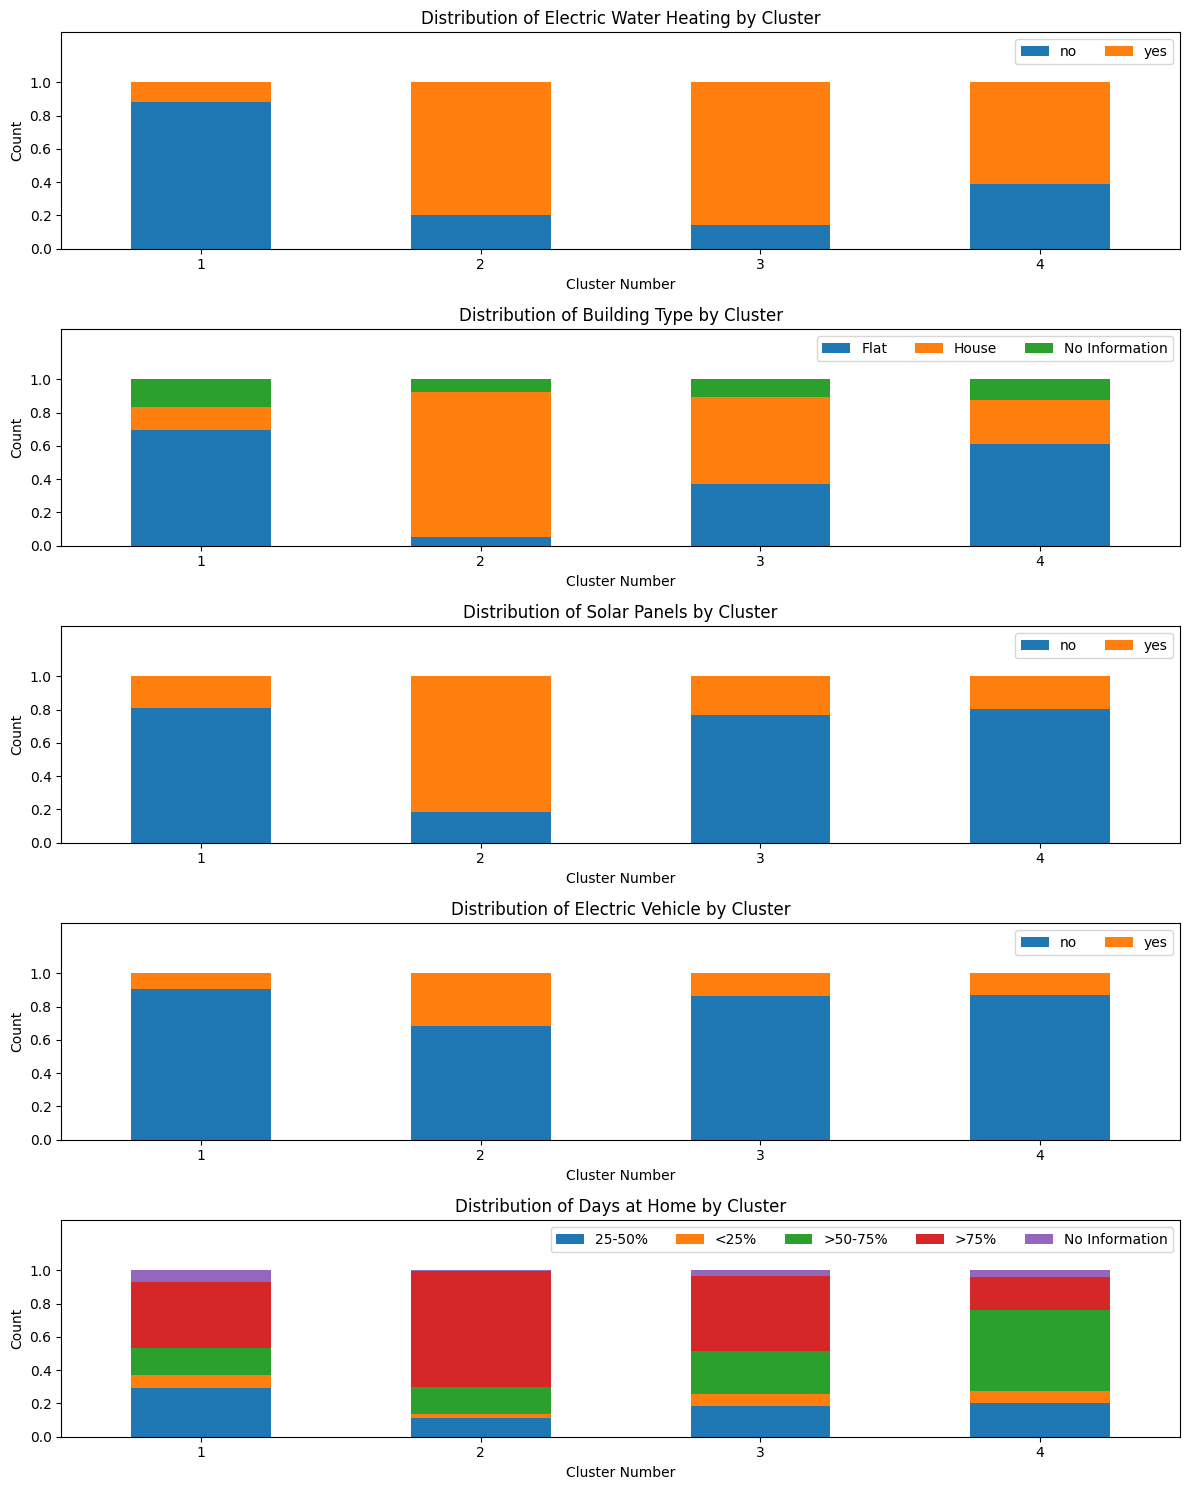

In [27]:
# Number of categorical features to plot
category_features = ['Electric Water Heating', 'Building Type', 'Solar Panels', 'Electric Vehicle', 'Days at Home']
n_features = len(category_features)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes only up to 1.15 (bars max out at 1, extra space for DR titles)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Rotate x-ticks for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=5,
    fontsize='medium'
)

plt.tight_layout()
plt.show()

In [ ]:
cluster_nums = [int(col.split()[1]) for col in final_table.columns]

# Calculate counts of samples per cluster from your cleaned df (df_cleaned)
cluster_counts = df_cleaned['cluster'].value_counts().sort_index()

# Extract counts matching the cluster numbers (fill with 0 if cluster missing)
counts_for_clusters = [cluster_counts.get(c, 0) for c in cluster_nums]

# Create DataFrame row with counts, row index MultiIndex
new_row = pd.DataFrame(
    [counts_for_clusters],
    columns=final_table.columns,
    index=pd.MultiIndex.from_tuples([('Number of Households', '')], names=final_table.index.names)
)

# Append new row at bottom
final_table_with_counts = pd.concat([final_table, new_row])

# Display with formatting
display(final_table_with_counts.style.format("{:.2%}"))